In [1]:
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
building_energy = pd.read_excel("../data/ENB2012_data.xlsx")

In [3]:
feature_names = [
    "Relative Compactness", "Surface Area", "Wall Area", 
    "Roof Area", "Overall Height", "Orientation", 
    "Glazing Area", "Glazing Area Distribution", "Heating Load", 
    "Cooling Load"
]

building_energy.columns = feature_names
building_energy.columns = (building_energy.columns
                           .str.replace(' ', '_')
                           .str.lower()
                        )

building_energy["energy_consumption"] = building_energy[["heating_load", "cooling_load"]].sum(axis=1)

In [4]:
X = building_energy.drop(["heating_load", "cooling_load", "energy_consumption"], axis=1)
y = building_energy["energy_consumption"]

In [5]:
building_energy.nunique()

relative_compactness          12
surface_area                  12
wall_area                      7
roof_area                      4
overall_height                 2
orientation                    4
glazing_area                   4
glazing_area_distribution      6
heating_load                 587
cooling_load                 636
energy_consumption           700
dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler()

X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)
X_test_scaled = torch.tensor(scaler.transform(X_test), dtype=torch.float)

y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

In [7]:
class GP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=train_x.shape[1]
                )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
noise = 1e-4
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GP(X_train_scaled, y_train, likelihood)
model.likelihood.noise = noise
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
num_iters = 100

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 150.97it/s]


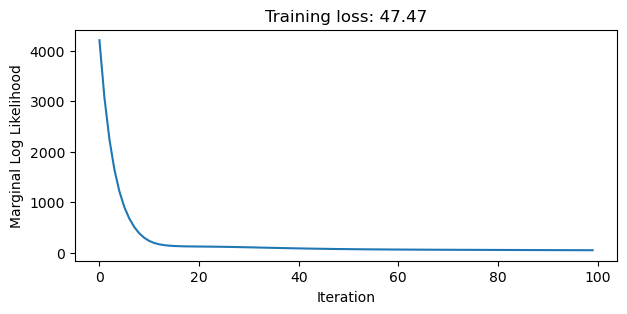

In [9]:
model.train()
likelihood.train()

loss_hist = []
for _ in tqdm(range(num_iters)):
    optimizer.zero_grad()
    output = model(X_train_scaled)
    loss = -mll(output, y_train)
    loss_hist.append(loss.item())

    loss.backward()
    optimizer.step()

plt.figure(figsize=(7, 3))
plt.plot(torch.arange(num_iters), loss_hist)
plt.xlabel("Iteration")
plt.ylabel("Marginal Log Likelihood")
plt.title(f"Training loss: {loss:.2f}");

In [10]:
model.covar_module.base_kernel.lengthscale

tensor([[0.1996, 0.2030, 0.2144, 0.3238, 0.3195, 0.4965, 0.6374, 0.2376]],
       grad_fn=<SoftplusBackward0>)

In [11]:
model.eval()
likelihood.eval()

with torch.no_grad():
    predictive_dist = likelihood(model(X_test_scaled))
    predictive_mean = predictive_dist.mean
    predictive_upper, predictive_lower = predictive_dist.confidence_region()

In [12]:
# metrics
nlpd = gpytorch.metrics.negative_log_predictive_density(predictive_dist, y_test)
mse = gpytorch.metrics.mean_squared_error(predictive_dist, y_test, squared=True)
mae = gpytorch.metrics.mean_absolute_error(predictive_dist, y_test)

In [13]:
nlpd, mse, mae

(tensor(81.5845), tensor(4.2413), tensor(1.3281))